Import Of The Important Libraries Required for Solving This Problem.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string 
import re
from nltk.corpus import stopwords
from collections import Counter
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import graphviz
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
os.listdir()

['Untitled.ipynb',
 'weights.best.hdf5',
 'model.png',
 '.ipynb_checkpoints',
 'negative.txt',
 'embedd_cnn_model.h5',
 'New Folder',
 'Sentiment_Analysis_Udacity.ipynb',
 'txt_sentoken',
 'vocab.txt',
 'review_polarity',
 'positive.txt',
 'cnn_model.png']

# Preprocessing Step 
# Import Data

In [61]:
# Function to load document into the notebook
def load_document(fileName):
    file=open(fileName,'r')
    text_data=file.read()
    file.close()
    return text_data

In [62]:
# Data Cleaning Step
# Turn a document into tokens after processing it.

def clean_document(document,m_type="mlp"):
    #split the review into tokens by white space
    tokens=document.split()
    # regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # removetokens which are not alphabetis
    if m_type=="mlp":
        tokens = [word for word in tokens if word.isalpha()]
        # remove stop words
        ##  A stop word is a commonly used word (such as “the”, “a”, “an”, “in”)
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]
        # remove out short tokens
        tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

In [63]:
filename="txt_sentoken/pos/cv001_18431.txt"
text=load_document(filename)
tokens=clean_document(text)
print(tokens)

['every', 'movie', 'comes', 'along', 'suspect', 'studio', 'every', 'indication', 'stinker', 'everybodys', 'surprise', 'perhaps', 'even', 'studio', 'film', 'becomes', 'critical', 'darling', 'mtv', 'films', 'election', 'high', 'school', 'comedy', 'starring', 'matthew', 'broderick', 'reese', 'witherspoon', 'current', 'example', 'anybody', 'know', 'film', 'existed', 'week', 'opened', 'plot', 'deceptively', 'simple', 'george', 'washington', 'carver', 'high', 'school', 'student', 'elections', 'tracy', 'flick', 'reese', 'witherspoon', 'overachiever', 'hand', 'raised', 'nearly', 'every', 'question', 'way', 'way', 'high', 'mr', 'matthew', 'broderick', 'sick', 'megalomaniac', 'student', 'encourages', 'paul', 'popularbutslow', 'jock', 'run', 'pauls', 'nihilistic', 'sister', 'jumps', 'race', 'well', 'personal', 'reasons', 'dark', 'side', 'sleeper', 'success', 'expectations', 'low', 'going', 'fact', 'quality', 'stuff', 'made', 'reviews', 'even', 'enthusiastic', 'right', 'cant', 'help', 'going', 'ba

In [64]:
# Function to save list to file
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [65]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [66]:
# directory='txt_sentoken/neg'
# for file in os.listdir(directory):
#     if file.endswith(".txt"):
#         doc=load_document(directory+'/'+file)
#         print("Loaded Document %s" % file)

# Develop Vocabulary

In [67]:
# Function to Load Document and then add the words to Vocab
def document_to_vocabulary(fileName,vocab):
    document=load_document(fileName)
    tokens=clean_document(document)
    vocab.update(tokens)

In [68]:
# Function to Process All the documents in the Directory
def process_documents(directory, vocab):
    count=0
    for fileName in os.listdir(directory):
        if fileName.endswith(".txt"):
            path=directory+"/"+fileName
            document_to_vocabulary(path,vocab)
            count+=1
    print("Total Number Of Files Processed In {d} = {n}".format(d=directory,n=count))

In [69]:
# Main Function To Process the documents 
# Global Varaible To Store The Count 

vocab = Counter()

def develop_vocab():
    global vocab
#     vocab= Counter()
    process_documents('txt_sentoken/neg', vocab)
    process_documents('txt_sentoken/pos', vocab)
    
    
    min_occur = 5
    
    tokens = [k for k,c in vocab.items() if c >= min_occur]
    save_list(tokens,"vocab.txt")

develop_vocab()

Total Number Of Files Processed In txt_sentoken/neg = 1000
Total Number Of Files Processed In txt_sentoken/pos = 1000


In [70]:
#Check Whether The File is Create or not 
if "vocab.txt" in os.listdir():
    print("TRUE")

TRUE


In [71]:
#print Length of the Vocabulary
print("Total Length Of The Vocabulary %s" %len(vocab))

Total Length Of The Vocabulary 46557


In [72]:
# 50 Most Common Words
print(vocab.most_common(50))

[('film', 8860), ('one', 5521), ('movie', 5440), ('like', 3553), ('even', 2555), ('good', 2320), ('time', 2283), ('story', 2118), ('films', 2102), ('would', 2042), ('much', 2024), ('also', 1965), ('characters', 1947), ('get', 1921), ('character', 1906), ('two', 1825), ('first', 1768), ('see', 1730), ('well', 1694), ('way', 1668), ('make', 1590), ('really', 1563), ('little', 1491), ('life', 1472), ('plot', 1451), ('people', 1420), ('movies', 1416), ('could', 1395), ('bad', 1374), ('scene', 1373), ('never', 1364), ('best', 1301), ('new', 1277), ('many', 1268), ('doesnt', 1267), ('man', 1266), ('scenes', 1265), ('dont', 1210), ('know', 1207), ('hes', 1150), ('great', 1141), ('another', 1111), ('love', 1089), ('action', 1078), ('go', 1075), ('us', 1065), ('director', 1056), ('something', 1048), ('end', 1047), ('still', 1038)]


# Top Ten Most Common Words

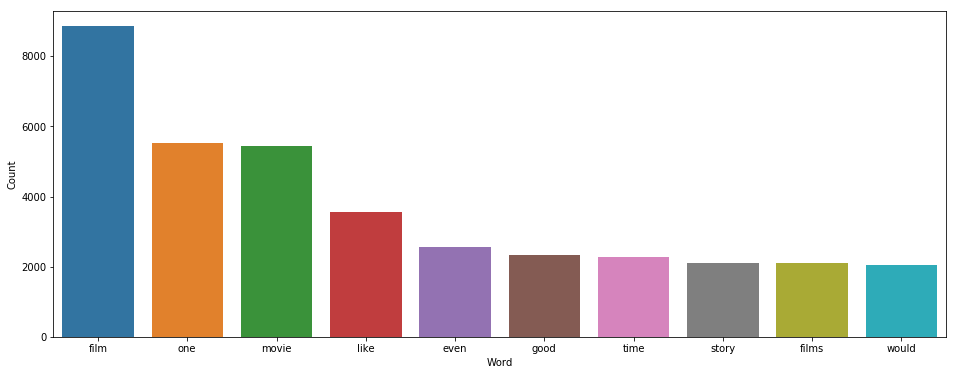

In [73]:
vocabmcdf=pd.DataFrame(data=vocab.most_common(10),columns=['Word','Count'])
plt.figure(figsize=(16,6))
sns.barplot(x='Word',y="Count",data=vocabmcdf)

In [74]:
#Load The Vocabulary from Vocab.txt File.

vocab_data=load_document("vocab.txt")
vocab_data=vocab_data.split()
vocab=set(vocab_data)
print("Number of Words in Vocab.txt is %s" %len(vocab))

Number of Words in Vocab.txt is 14803


# Prepare Review For Modeling

Creating Negative.txt and Positive.txt from all the review documents.

In [75]:
def process_review_documents(directory,vocab,train=False,op=0,m_type="mlp"):
    lines=[]
    count=0
    for file in os.listdir(directory):
#         print(file)
        if file.endswith(".txt"):
            if not op:
                if train and file.startswith("cv9"):
                    continue
                if not train and not file.startswith("cv9"):
                    continue
            count=count+1
            file_path=directory + '/' + file
            lines_in_file=load_document(file_path)
            tokens=clean_document(lines_in_file,m_type)
            tokens=[w for w in tokens if w in vocab]
            line=' '.join(tokens)
        lines.append(line)
#         print(lines)
    print("Number of File Processed in {d} is {n}".format(d=directory,n=count))
    return lines

# Negative lines from all the documents from "txt_sentoken/neg"

In [76]:
# Negative lines from all the documents from "txt_sentoken/neg"
neg_lines=process_review_documents("txt_sentoken/neg",vocab_data,op=1)
save_list(neg_lines,"negative.txt")

#Load Negative Lines From negative.txt
negative_lines=load_document("negative.txt")
print("Length of the Negative.txt File is %s " %len(negative_lines))


Number of File Processed in txt_sentoken/neg is 1000
Length of the Negative.txt File is 2124581 


In [77]:
print(negative_lines[:100])

studio attracted many weird bizarre people gates wonder film life death studio centers one boring cl


# Positive lines from all the documents from "txt_sentoken/pos"

In [78]:
# Negative lines from all the documents from "txt_sentoken/neg"
pos_lines=process_review_documents("txt_sentoken/pos",vocab_data,op=1)
save_list(pos_lines,"positive.txt")

#Load Negative Lines From negative.txr
positive_lines=load_document("positive.txt")
print("Length of the Positive.txt File is %s " %len(positive_lines))


Number of File Processed in txt_sentoken/pos is 1000
Length of the Positive.txt File is 2408780 


In [79]:
print(positive_lines[:100])

david lynchs blue velvet begins ends colorful bright shots flowers happy americans seemingly perfect


In [80]:
def load_clean_dataset(vocab,op,train=False,m_type="mlp"):
    neg=process_review_documents('txt_sentoken/neg', vocab,train,op,m_type)
    pos=process_review_documents('txt_sentoken/pos', vocab,train,op,m_type)
    docs=neg+pos
    print("Length of   Negative Files = {n} \t Positive Files= {p} \t Doc = {d} ".format(n=len(neg),p=len(pos),d=len(docs)))
    labels =[0 for i in range(len(neg))] + [1 for j in range(len(pos))]
    return docs,labels
    

# Train Test Split

Dividing 90% 10% Ration 1000 Review Document

# Load Training DataSet

In [81]:
# load all training reviews
train_docs, ytrain = load_clean_dataset(vocab,train=True,op=0)


Number of File Processed in txt_sentoken/neg is 900
Number of File Processed in txt_sentoken/pos is 900
Length of   Negative Files = 900 	 Positive Files= 900 	 Doc = 1800 


In [82]:
print(len(train_docs))

1800


In [83]:
print(len(ytrain))

1800


# Load Test DataSet

In [84]:
test_docs, ytest = load_clean_dataset(vocab,train=False,op=0)

Number of File Processed in txt_sentoken/neg is 100
Number of File Processed in txt_sentoken/pos is 100
Length of   Negative Files = 100 	 Positive Files= 100 	 Doc = 200 


# Keras Tokenizer To Implement Bag Of Words

In [85]:
# Function To Tokenize
def create_tokenizer(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [86]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [87]:
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

(1800, 14781) (200, 14781)


# Benchmark Model

In [88]:
n_words=Xtest.shape[1]
n_words

14781

In [89]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(25, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [90]:
#fit network
model=define_model(n_words)
model.fit(Xtrain, ytrain, epochs=10, verbose=2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 25)                369550    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26        
Total params: 369,576
Trainable params: 369,576
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 1s - loss: 0.6921 - acc: 0.5406
Epoch 2/10
 - 1s - loss: 0.6853 - acc: 0.8189
Epoch 3/10
 - 1s - loss: 0.6749 - acc: 0.6944
Epoch 4/10
 - 1s - loss: 0.6577 - acc: 0.8933
Epoch 5/10
 - 1s - loss: 0.6347 - acc: 0.9133
Epoch 6/10
 - 1s - loss: 0.6090 - acc: 0.9244
Epoch 7/10
 - 1s - loss: 0.5799 - acc: 0.9206
Epoch 8/10
 - 1s - loss: 0.5487 - acc: 0.9333
Epoch 9/10
 - 1s - loss: 0.5177 - acc: 0.9350
Epoch 10/10
 - 1s - loss: 0.4865 - acc: 0.9422


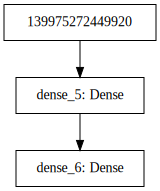

In [93]:
#Plot of The Defined model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [94]:
# evaluate
loss, acc  = model.evaluate(Xtest, ytest, verbose=0)
print('Test Loss: %f' % (loss*100))
print('Test Accuracy: %f' % (acc*100))

Test Loss: 54.650734
Test Accuracy: 86.500000


# Predicting Sentiment For Reviews For Benchmark Model.


In [95]:
def predict_sentiment(review, vocab, tokenizer, model):
    tokens = clean_document(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    encoded = tokenizer.texts_to_matrix([line], mode='freq')
    yhat = model.predict(encoded, verbose=0)
    percent_pos = yhat[0,0]
    if percent_pos < 0.5:
        return (1-percent_pos), 'NEGATIVE'
    else:
            if percent_pos >0.5 and percent_pos<0.505:
                return percent_pos, 'NEUTRAL'
            else:
                return percent_pos, 'POSITIVE'

In [96]:
#
# MLP
#
m_type="mlp"

text = 'It is an ok movie one time watch'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text

text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'An above average one for one time watch.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))


text = 'Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters \
I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just \
cant be with her? Please. This movie will become a cult movie and will get good rating because people will be afraid to speak the truth, which was, this movie wasnt very good.\
However, I feel that the sequel might be better because they dont have to build up the character so much..'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'Spiderman was just ok. Its not the greatest comic book movie. I still prefer the original Batman movie, Superman and The Daredevil movie. Spiderman had a few cool scenes \
but overall I was disappointed. Tobey was pretty good. Kirsten, uhh, liked her in Virgin Suicide, \
wasnt digging her in this role. Fell flat in my opinion.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [It is an ok movie one time watch]
Sentiment: NEGATIVE (66.353%)
Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (75.885%)
Review: [This is a bad movie.]
Sentiment: NEGATIVE (99.251%)
Review: [An above average one for one time watch.]
Sentiment: POSITIVE (57.173%)
Review: [Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just cant be with her? Please. This movie will become a cult movie and will get good rating because people will be afraid to speak the truth, which was, this movie wasnt very good.However, I feel that the sequel might be better because they dont have to build up the character so much..]
Sentiment: NEGATIVE (78.330%)
Review: [Spiderman was just ok. Its not the greatest comic book movie. I still prefer the original Batman movie, 

# CNN with Embedding Layer Model

I will test different options to see which gives the best result on this problem .

CNN With Embedding Layer

In [97]:
#Load Train And test Set for Embedding 

cnn_train_docs, ytrain = load_clean_dataset(vocab, train=True,op=0,m_type="cnn")
cnn_test_docs, ytest = load_clean_dataset(vocab,train=False,op=0,m_type="cnn")

Number of File Processed in txt_sentoken/neg is 900
Number of File Processed in txt_sentoken/pos is 900
Length of   Negative Files = 900 	 Positive Files= 900 	 Doc = 1800 
Number of File Processed in txt_sentoken/neg is 100
Number of File Processed in txt_sentoken/pos is 100
Length of   Negative Files = 100 	 Positive Files= 100 	 Doc = 200 


In [98]:
max_length = max([len(s.split()) for s in cnn_train_docs])
print('Maximum length: %d' % max_length)

Maximum length: 1244


In [99]:
def encode_documents(tokenizer ,max_length,docs):
    encoded=tokenizer.texts_to_sequences(docs)
    padded=pad_sequences(encoded,maxlen=max_length,padding='post')
    return padded

In [100]:
def define_embed_cnn_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     filepath="weights.best.hdf5"
#     checkpoint = ModelCheckpoint(filepath, monitor= 'val_acc' , verbose=1, save_best_only=True,
#     mode= max )
#     callbacks_list = [checkpoint]
    # summarize defined model
    model.summary()
    plot_model(model, to_file='cnn_model.png', show_shapes=True)
#     return model,callbacks_list
    return model

In [101]:
cnn_tokenizer=create_tokenizer(cnn_train_docs)
vocabulary_size=len(cnn_tokenizer.word_index)+1
print("Vocabulary Size %d"%vocabulary_size)

Vocabulary Size 14781


In [102]:
def predict_sentiment(review, vocab, tokenizer,max_length, model):
    tokens = clean_document(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    padded=encode_documents(tokenizer,max_length,[line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    percent_pos = yhat[0,0]
    print(percent_pos)
    if percent_pos < 0.49:
        return (1-percent_pos), 'NEGATIVE'
    else:
        if percent_pos >0.5 and percent_pos<0.5045:
            return percent_pos, 'NEUTRAL'
        else:
            return percent_pos, 'POSITIVE'cnn_Xtrain = encode_documents(cnn_tokenizer, max_length, cnn_train_docs)
cnn_Xtest = encode_documents(cnn_tokenizer, max_length, cnn_test_docs)

print(len(cnn_Xtrain))
print(len(cnn_Xtest))

1800
200


In [103]:
embed_cnn_model=define_embed_cnn_model(vocabulary_size,max_length)

# embed_cnn_model,callb=define_embed_cnn_model(vocabulary_size,max_length)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1244, 100)         1478100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1237, 32)          25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 618, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 19776)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                197770    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 1,701,513
Trainable params: 1,701,513
Non-trainable params: 0
_________________________________________________________________


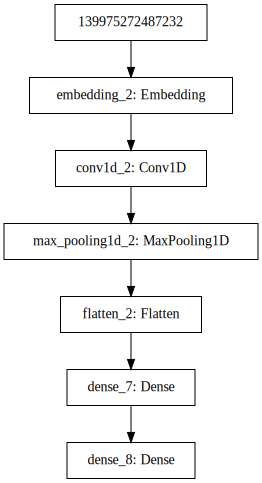

In [104]:
#Plot of The Defined model
SVG(model_to_dot(embed_cnn_model).create(prog='dot', format='svg'))

In [106]:
embed_cnn_model.fit(cnn_Xtrain, ytrain, epochs=10, verbose=2)

# history=embed_cnn_model.fit(cnn_Xtrain, ytrain,validation_split=0.20 ,epochs=10, verbose=0,batch_size=100,callbacks=callb)

Epoch 1/10
 - 16s - loss: 0.0082 - acc: 0.9994
Epoch 2/10
 - 16s - loss: 0.0028 - acc: 1.0000
Epoch 3/10
 - 15s - loss: 0.0017 - acc: 1.0000
Epoch 4/10
 - 18s - loss: 0.0012 - acc: 1.0000
Epoch 5/10
 - 17s - loss: 9.1946e-04 - acc: 1.0000
Epoch 6/10
 - 15s - loss: 7.4073e-04 - acc: 1.0000
Epoch 7/10
 - 23s - loss: 6.1273e-04 - acc: 1.0000
Epoch 8/10
 - 22s - loss: 5.1725e-04 - acc: 1.0000
Epoch 9/10
 - 14s - loss: 4.4312e-04 - acc: 1.0000
Epoch 10/10
 - 13s - loss: 3.8333e-04 - acc: 1.0000


# History Of Accuracy And Loss

In [46]:
# 
# print(h`istory.history.keys())

# # history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['loss'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# # history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Evaluate Cnn Model 

In [107]:
# evaluate Train Accuracy and Loss
cnn_loss, cnn_acc  = embed_cnn_model.evaluate(cnn_Xtrain, ytrain, verbose=0)
print('Train Loss: %f' % (cnn_loss*100))
print('Train Accuracy: %f\n' % (cnn_acc*100))

# evaluate Test Accuracy and Loss
cnn_loss, cnn_acc  = embed_cnn_model.evaluate(cnn_Xtest, ytest, verbose=0)
print('Test Loss: %f' % (cnn_loss*100))
print('Test Accuracy: %f' % (cnn_acc*100))

Train Loss: 0.034324
Train Accuracy: 100.000000

Test Loss: 64.727827
Test Accuracy: 88.500000


Save Model

In [48]:
# model.save('embedd_cnn_model.h5')

In [111]:
def predict_sentiment(review, vocab, tokenizer,max_length, model):
    tokens = clean_document(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    padded=encode_documents(tokenizer,max_length,[line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    percent_pos = yhat[0,0]
    print(percent_pos)
    if percent_pos < 0.49:
        return (1-percent_pos), 'NEGATIVE'
    else:
        if percent_pos >0.5 and percent_pos<0.5045:
            return percent_pos, 'NEUTRAL'
        else:
            return percent_pos, 'POSITIVE'

In [108]:
# def predict_sentiment(review, vocab, tokenizer,max_length, model):
#     tokens = clean_document(review)
#     tokens = [w for w in tokens if w in vocab]
#     line = ' '.join(tokens)
#     padded=encode_documents(tokenizer,max_length,[line])
#     # predict sentiment
#     yhat = model.predict(padded, verbose=0)
#     percent_pos = yhat[0,0]
#     print(percent_pos)
#     if round(percent_pos) == 0:
#         return (1-percent_pos), 'NEGATIVE'
#     return percent_pos, 'POSITIVE'

In [57]:
# embed_cnn_model.load_weights("weights.best.hdf5")
# embed_cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
text = 'It is an ok movie one time watch'
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters \
I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just \
cant be with her? Please. This movie will become a cult movie and will get good rating because people will be afraid to speak the truth, which was, this movie wasnt very good.\
However, I feel that the sequel might be better because they dont have to build up the character so much..'

percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'Spiderman was just ok. Its not the greatest comic book movie. I still prefer the original Batman movie, Superman and The Daredevil movie. Spiderman had a few cool scenes \
but overall I was disappointed. Tobey was pretty good. Kirsten, uhh, liked her in Virgin Suicide, \
wasnt digging her in this role. Fell flat in my opinion.'
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = "The best story ever told on film"
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'An above average one for one time watch.'
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

0.50380456
Review: [It is an ok movie one time watch]
Sentiment: NEUTRAL (50.380%)
0.42502362
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (57.498%)
0.07515951
Review: [Give me a break. Top 200 movie of all time? Not even close. The bad guy in the movie was one of the worst characters I ever seen. It just was not a very good flick. It tried to build up the love between Peter Parker and the girl and then all of a sudden, he just cant be with her? Please. This movie will become a cult movie and will get good rating because people will be afraid to speak the truth, which was, this movie wasnt very good.However, I feel that the sequel might be better because they dont have to build up the character so much..]
Sentiment: NEGATIVE (92.484%)
0.3330463
Review: [Spiderman was just ok. Its not the greatest comic book movie. I still prefer the original Batman movie, Superman and The Daredevil movie. Spiderman had a few cool scenes but overall I was disappointed. T

In [113]:
text = 'Everyone will enjoy this film. I love it, recommended!'
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = "Very heart touching and making us proud movie. The acting done \
by akshay Kumar is awesome in the movie.   \
The whole theater was emotional at the end of the movie."

percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'I loved This Movie. I would recommend this movie to everyone.'
percent, sentiment = predict_sentiment(text, vocab, cnn_tokenizer, max_length, embed_cnn_model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

0.5167485
Review: [Everyone will enjoy this film. I love it, recommended!]
Sentiment: POSITIVE (51.675%)
0.42502362
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (57.498%)
0.32660693
Review: [Very heart touching and making us proud movie. The acting done by akshay Kumar is awesome in the movie.   The whole theater was emotional at the end of the movie.]
Sentiment: NEGATIVE (67.339%)
0.492226
Review: [I loved This Movie. I would recommend this movie to everyone.]
Sentiment: POSITIVE (49.223%)


# Compare Word Scoring 

In [53]:
# modes= ['binary', 'count', 'tfidf', 'freq']
# #Prepare Bag - Of - Words Encoding
# results=pd.DataFrame()
# def prepare_data(train,test,m):
#     token=Tokenizer()
#     token.fit_on_texts(train)
#     Xtrain=token.texts_to_matrix(train, mode=mode)
#     Xtest = token.texts_to_matrix(test, mode=mode)
#     return Xtrain,Xtest

# #Evaluate
# def evaluate_mode(Xtrain,ytrain,Xtest,ytest):
#     scores=list()
#     no_r=10
#     for _ in range(no_r):
#         model=Sequential() 
#         model.add(Dense(50,input_shape=(n_words,),activation='relu'))
#         model.add(Dense(1,activation='sigmoid'))
#         model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#         model.fit(Xtrain,ytrain,epochs=10,verbose=1)
#         loss,acc=model.evaluate(Xtest,ytest,verbose=1)
#         scores.append(acc)
#         print("%d accuracy : %s "%((_+1),acc))
#     return scores

# for mode in modes:
#     Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
#     results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)



In [54]:
# print(results.describe())
# plt.figure(figsize=(16,6))
# results.boxplot()
# plt.xlabel("Types")
# plt.ylabel("Accuracy")
# plt.show()
